In [6]:
%pip install --upgrade --quiet pip
%pip install --upgrade --quiet pandas scikit-learn lightgbm seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [7]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
df = pd.read_csv('data/learning_table.csv', sep=',')
df = df.drop(['target', 'sequence', 'date', 'obj_type', 'group'], axis=1)
print(df.head())
class_distribution = df['shifted_target'].value_counts()
print(class_distribution)

   coal_temp  temp_max  temp_mean  humidity_max  humidity_mean  precipitation  \
0       34.8      22.9  21.454167            90      84.875000            0.8   
1       31.2      22.7  22.220833            90      84.333333            0.9   
2       35.1      24.8  23.258333            91      81.041667            3.9   
3       33.2      27.0  24.983333            85      73.208333            0.0   
4       36.1      25.2  23.691667            72      58.708333            0.0   

      v_mean      v_max       p_mean   p_max  ...  autumn  shifted_target  \
0  12.891667  18.733333  1005.191667  1006.5  ...       0             0.0   
1  13.991667  19.979167  1008.475000  1010.6  ...       0             0.0   
2  14.400000  23.579167  1011.158333  1013.1  ...       0             0.0   
3  11.591667  16.400000  1013.237500  1013.7  ...       0             0.0   
4  22.812500  30.820833  1013.416667  1014.3  ...       0             0.0   

   coal_temp_rolling_mean  coal_temp_deviation  mo

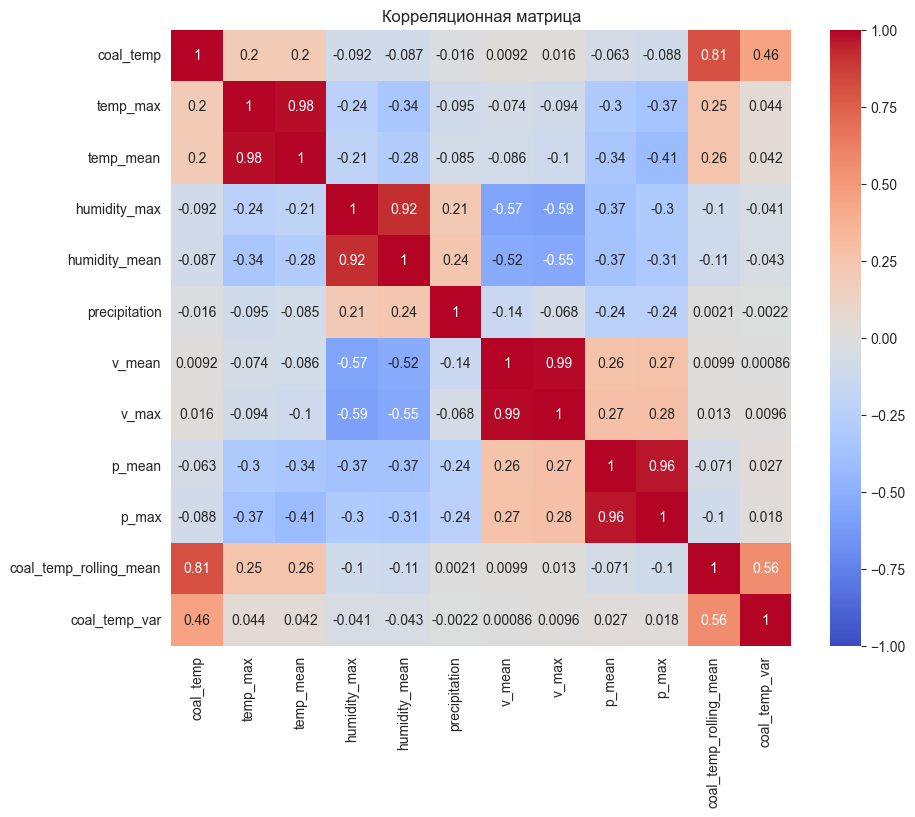

   coal_temp  temp_max  temp_mean  humidity_max  humidity_mean  precipitation  \
0       34.8      22.9  21.454167            90      84.875000            0.8   
1       31.2      22.7  22.220833            90      84.333333            0.9   
2       35.1      24.8  23.258333            91      81.041667            3.9   
3       33.2      27.0  24.983333            85      73.208333            0.0   
4       36.1      25.2  23.691667            72      58.708333            0.0   

      v_mean      v_max       p_mean   p_max  coal_temp_rolling_mean  \
0  12.891667  18.733333  1005.191667  1006.5                   34.80   
1  13.991667  19.979167  1008.475000  1010.6                   33.00   
2  14.400000  23.579167  1011.158333  1013.1                   35.10   
3  11.591667  16.400000  1013.237500  1013.7                   34.15   
4  22.812500  30.820833  1013.416667  1014.3                   34.80   

   coal_temp_var  
0         3.2400  
1         3.2400  
2         8.5321  
3   

In [66]:
X = df.drop(columns=['summer', 'spring', 'autumn', 'shifted_target', 'coal_temp_deviation', 'month'
                     ,'coal_temp_p_mean', 'coal_temp_lag2d', 'coal_temp_lag1d', 'coal_temp_lag3d'])
correlation_matrix = X.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,  # Показать значения в ячейках
    cmap='coolwarm',  # Цветовая схема
    vmin=-1, vmax=1  # Диапазон значений
)
plt.title('Корреляционная матрица')
plt.show()

print(X.head())
y = df.iloc[:, -9]
print(y.head())

In [67]:
# Предполагая, что X - фичи, y - целевая переменная (shifted_target)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,  # Для сохранения баланса классов
    random_state=42
)

print(X_train.head())
print(X_test.head())
print(y_train.head())

# Создание датасета для LightGBM
train_data = lgb.Dataset(X_train, label=y_train)

      coal_temp  temp_max  temp_mean  humidity_max  humidity_mean  \
105        33.0      17.3  15.908333            97      87.083333   
1044      151.0      20.9  20.233333            92      87.416667   
1094      273.0      28.0  25.904167            75      64.375000   
882        36.5      25.6  23.600000            78      64.541667   
390        35.7      28.4  25.745833            96      81.125000   

      precipitation     v_mean      v_max       p_mean   p_max  \
105             1.0   7.675000  12.083333  1007.833333  1009.4   
1044            0.0  16.920833  23.466667  1005.229167  1006.0   
1094            0.0  23.454167  31.291667  1013.379167  1014.2   
882             0.0  18.066667  25.233333  1014.020833  1014.9   
390             0.1  17.212500  23.208333  1005.525000  1010.9   

      coal_temp_rolling_mean  coal_temp_var  
105                32.366667      35.034737  
1044               97.033333   16825.009492  
1094              241.333333    8822.106538  
882 

In [70]:
scale_pos_weight = 5.1

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 7,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'verbose': -1,
    'seed': 42,
    "scale_pos_weight": scale_pos_weight
}

model = lgb.train(
    params,
    train_data,
    num_boost_round=150,
    valid_sets=[train_data]
)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.88      0.93       255
         1.0       0.54      0.90      0.68        41

    accuracy                           0.88       296
   macro avg       0.76      0.89      0.80       296
weighted avg       0.92      0.88      0.89       296



<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

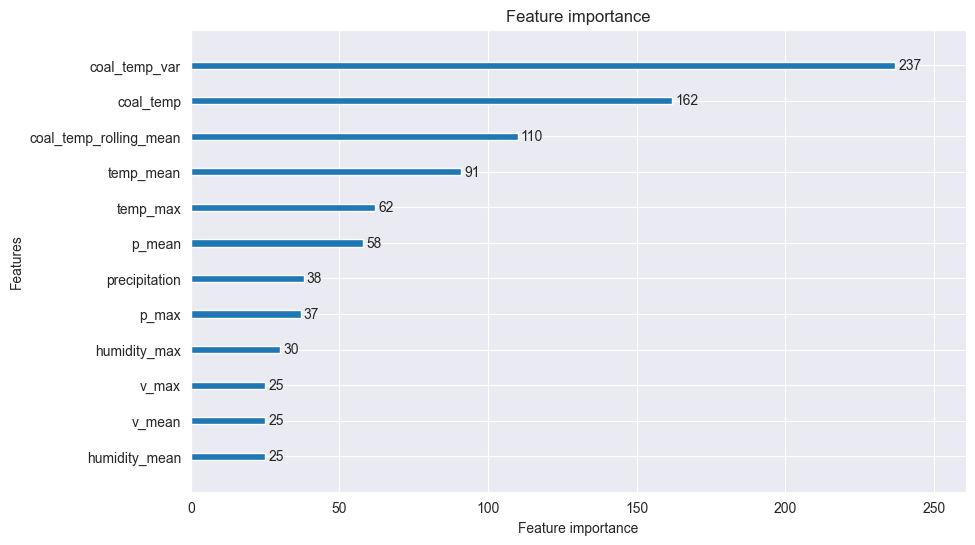

In [71]:
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_class))

# Важность признаков
lgb.plot_importance(model, figsize=(10, 6), max_num_features=15)

In [58]:
model.save_model('model.txt')